In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
### SVM without resnet

# Updated file paths to exclude ResNet features
file_paths_without_resnet = {
    "LBP": {
        "train": r"features\train_lbp_features.csv",
        "val": r"features\val_lbp_features.csv",
        "test": r"features\test_lbp_features.csv",
    },
    "GLCM": {
        "train": r"features\train_glcm_features.csv",
        "val": r"features\val_glcm_features.csv",
        "test": r"features\test_glcm_features.csv",
    },
    "Gabor": {
        "train": r"features\train_gabor_features.csv",
        "val": r"features\val_gabor_features.csv",
        "test": r"features\test_gabor_features.csv",
    },
}

# Step 1: Load features from CSV files
def load_features(file_paths):
    features = []
    labels = None

    for method, paths in file_paths.items():
        df = pd.read_csv(paths["train"])
        features.append(df.drop(columns=["label"]).values)  # Drop label column
        if labels is None:
            labels = df["label"].values  # Use labels from the first feature type
        else:
            assert np.array_equal(labels, df["label"].values), "Labels mismatch between features!"

    return np.hstack(features), labels  # Combine features horizontally and return labels

# Step 2: Clean invalid values in the features
def clean_features(features):
    """
    Cleans the input features by handling invalid values:
    - Replaces NaN with 0
    - Replaces +inf with 1e6 and -inf with -1e6
    - Clips extreme values to the range [-1e6, 1e6]
    """
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    features = np.clip(features, -1e6, 1e6)
    return features

# Load and clean features without ResNet
train_features, train_labels = load_features(file_paths_without_resnet)
train_features = clean_features(train_features)

val_features, val_labels = load_features({k: {"train": v["val"]} for k, v in file_paths_without_resnet.items()})
val_features = clean_features(val_features)

test_features, test_labels = load_features({k: {"train": v["test"]} for k, v in file_paths_without_resnet.items()})
test_features = clean_features(test_features)

# Normalize the training features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)

# Fit PCA on training features
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
train_features_reduced = pca.fit_transform(train_features_normalized)

print(f"Number of components capturing 95% variance (without ResNet): {pca.n_components_}")

# Transform validation and test features using the same PCA
val_features_normalized = scaler.transform(val_features)  # Use the same scaler
val_features_reduced = pca.transform(val_features_normalized)

test_features_normalized = scaler.transform(test_features)  # Use the same scaler
test_features_reduced = pca.transform(test_features_normalized)

# Train an SVM model
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(train_features_reduced, train_labels)

# Validate the model
val_predictions = svm_model.predict(val_features_reduced)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy (without ResNet): {val_accuracy}")
print("Validation Classification Report (without ResNet):")
print(classification_report(val_labels, val_predictions))

# Test the model
test_predictions = svm_model.predict(test_features_reduced)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy (without ResNet): {test_accuracy}")
print("Test Classification Report (without ResNet):")
print(classification_report(test_labels, test_predictions))


Number of components capturing 95% variance (without ResNet): 72
Validation Accuracy (without ResNet): 0.5132530120481927
Validation Classification Report (without ResNet):
              precision    recall  f1-score   support

    backpack       0.58      0.73      0.65        49
        bike       0.59      0.72      0.65        40
  calculator       0.45      0.49      0.47        41
  headphones       0.52      0.51      0.52        43
    keyboard       0.50      0.44      0.47        39
      laptop       0.38      0.37      0.37        46
     monitor       0.55      0.52      0.54        42
       mouse       0.53      0.49      0.51        43
         mug       0.50      0.31      0.38        36
   projector       0.49      0.50      0.49        36

    accuracy                           0.51       415
   macro avg       0.51      0.51      0.50       415
weighted avg       0.51      0.51      0.51       415

Test Accuracy (without ResNet): 0.5775656324582339
Test Classificati

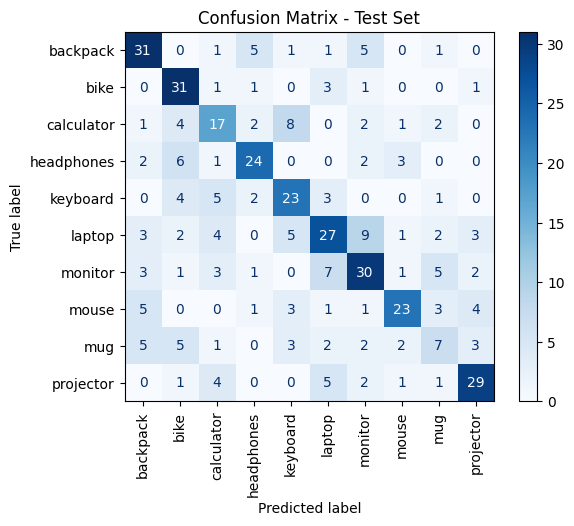

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Predict on the test set using the trained SVM model
test_predictions = svm_model.predict(test_features_reduced)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Set")
plt.show()
